# **Proyecto Parcial 1: Regresión**

Para este proyecto se utilizó una base de datos llamada **Superconductivity Data** obtenida del [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/464/superconductivty+data).

La base de diferentes datos y mediciones sobre **21263** materiales superconductores distintos. En total, en la base hay **81 variables** de las cuales todas son de tipo numérico, algunos enteros y otros continuos.

La variable de interés es la Temperatura Crítica (**critical_temp**) ya que esta es una característica muy importante en la aplicación de superconductores en la ingeniería, y poder predecir cual sera la temperatura crítica de un superconductor puede contribuir a la integración de superconductores en nuevas tecnologías.

In [11]:
import pandas as pd
df = pd.read_csv("train.csv")
print("Número de Observaciones:",df.shape[0])
print("Número de Variables:",df.shape[1]-1)
print("Variable de interes:",df.columns.tolist()[81])
print("\nTodas las Variables:")
for i in df.columns:
  print("-",i)

Número de Observaciones: 21263
Número de Variables: 81
Variable de interes: critical_temp

Todas las Variables:
- number_of_elements
- mean_atomic_mass
- wtd_mean_atomic_mass
- gmean_atomic_mass
- wtd_gmean_atomic_mass
- entropy_atomic_mass
- wtd_entropy_atomic_mass
- range_atomic_mass
- wtd_range_atomic_mass
- std_atomic_mass
- wtd_std_atomic_mass
- mean_fie
- wtd_mean_fie
- gmean_fie
- wtd_gmean_fie
- entropy_fie
- wtd_entropy_fie
- range_fie
- wtd_range_fie
- std_fie
- wtd_std_fie
- mean_atomic_radius
- wtd_mean_atomic_radius
- gmean_atomic_radius
- wtd_gmean_atomic_radius
- entropy_atomic_radius
- wtd_entropy_atomic_radius
- range_atomic_radius
- wtd_range_atomic_radius
- std_atomic_radius
- wtd_std_atomic_radius
- mean_Density
- wtd_mean_Density
- gmean_Density
- wtd_gmean_Density
- entropy_Density
- wtd_entropy_Density
- range_Density
- wtd_range_Density
- std_Density
- wtd_std_Density
- mean_ElectronAffinity
- wtd_mean_ElectronAffinity
- gmean_ElectronAffinity
- wtd_gmean_Electr

## **Huecos**

La base de datos cuenta con algunos **huecos** los cuales fueron detectados al momento de intentar generar un modelo de regresión lineal con los datos sin procesar, a manera de prueba. Para resolver esto, se utiliza la funcion `dropna(`) de `pandas` y se elimina toda aquella columna con huecos **NaN**.

In [25]:
df = df.dropna()

15667


## **Outliers**

Para identificar **valores atípicos**, se utiliza el **método de Tukey** y se calcula el **rango intercuartíl** de todas y cada una de las variables y se eliminan las columnas que tengan valores fuera del rango. Tras esta acción, se **reduce el número de observaciones**.

In [13]:
import numpy as np
df_filtrado = df.copy()
for column in df.columns:
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - 3 * IQR
  upper_bound = Q3 + 3 * IQR
  df_filtrado = df_filtrado[(df_filtrado[column] >= lower_bound) & (df_filtrado[column] <= upper_bound)]
print("Nuevo número de observaciones:",df_filtrado.shape[0])
df= df_filtrado

Nuevo número de observaciones: 15667


## **Colinearidad**

En esta base de datos, muchas de las variables son medias u otros estadísticos de una misma variable, por lo cual pueden provocar **colinearidad**. Para identificar si existe este problema se genera un **heatmap** donde se muestre visualmente, una **matriz de correlaciones** entre las variables.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
y = df['critical_temp']
x = df.drop(columns = ['critical_temp'])
corr_matrix = x.corr()
plt.figure(figsize=(100,100))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f",linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Como era esperado, hay una **gran cantidad de variables que muestran colinealidad** alta, para erradicar esto, de cada par de variables con **correlación mayor o igual a 0.9**, se **eliminará una de ellas**. Tras esto se reduce el número de variables.

columnas eliminadas por alta correlación: {'wtd_std_ElectronAffinity', 'wtd_entropy_Valence', 'wtd_std_atomic_radius', 'std_Density', 'wtd_gmean_Density', 'wtd_gmean_atomic_mass', 'gmean_fie', 'std_atomic_radius', 'entropy_atomic_mass', 'gmean_Density', 'std_ThermalConductivity', 'wtd_entropy_atomic_radius', 'wtd_gmean_fie', 'wtd_std_Density', 'entropy_Valence', 'wtd_std_ThermalConductivity', 'wtd_mean_atomic_radius', 'wtd_std_atomic_mass', 'std_fie', 'gmean_FusionHeat', 'gmean_Valence', 'entropy_Density', 'range_atomic_radius', 'entropy_FusionHeat', 'wtd_gmean_FusionHeat', 'wtd_std_fie', 'wtd_std_FusionHeat', 'std_Valence', 'std_atomic_mass', 'wtd_gmean_Valence', 'wtd_range_ThermalConductivity', 'entropy_atomic_radius', 'wtd_mean_Valence', 'std_FusionHeat', 'wtd_gmean_atomic_radius', 'entropy_fie', 'std_ElectronAffinity', 'wtd_mean_FusionHeat'}


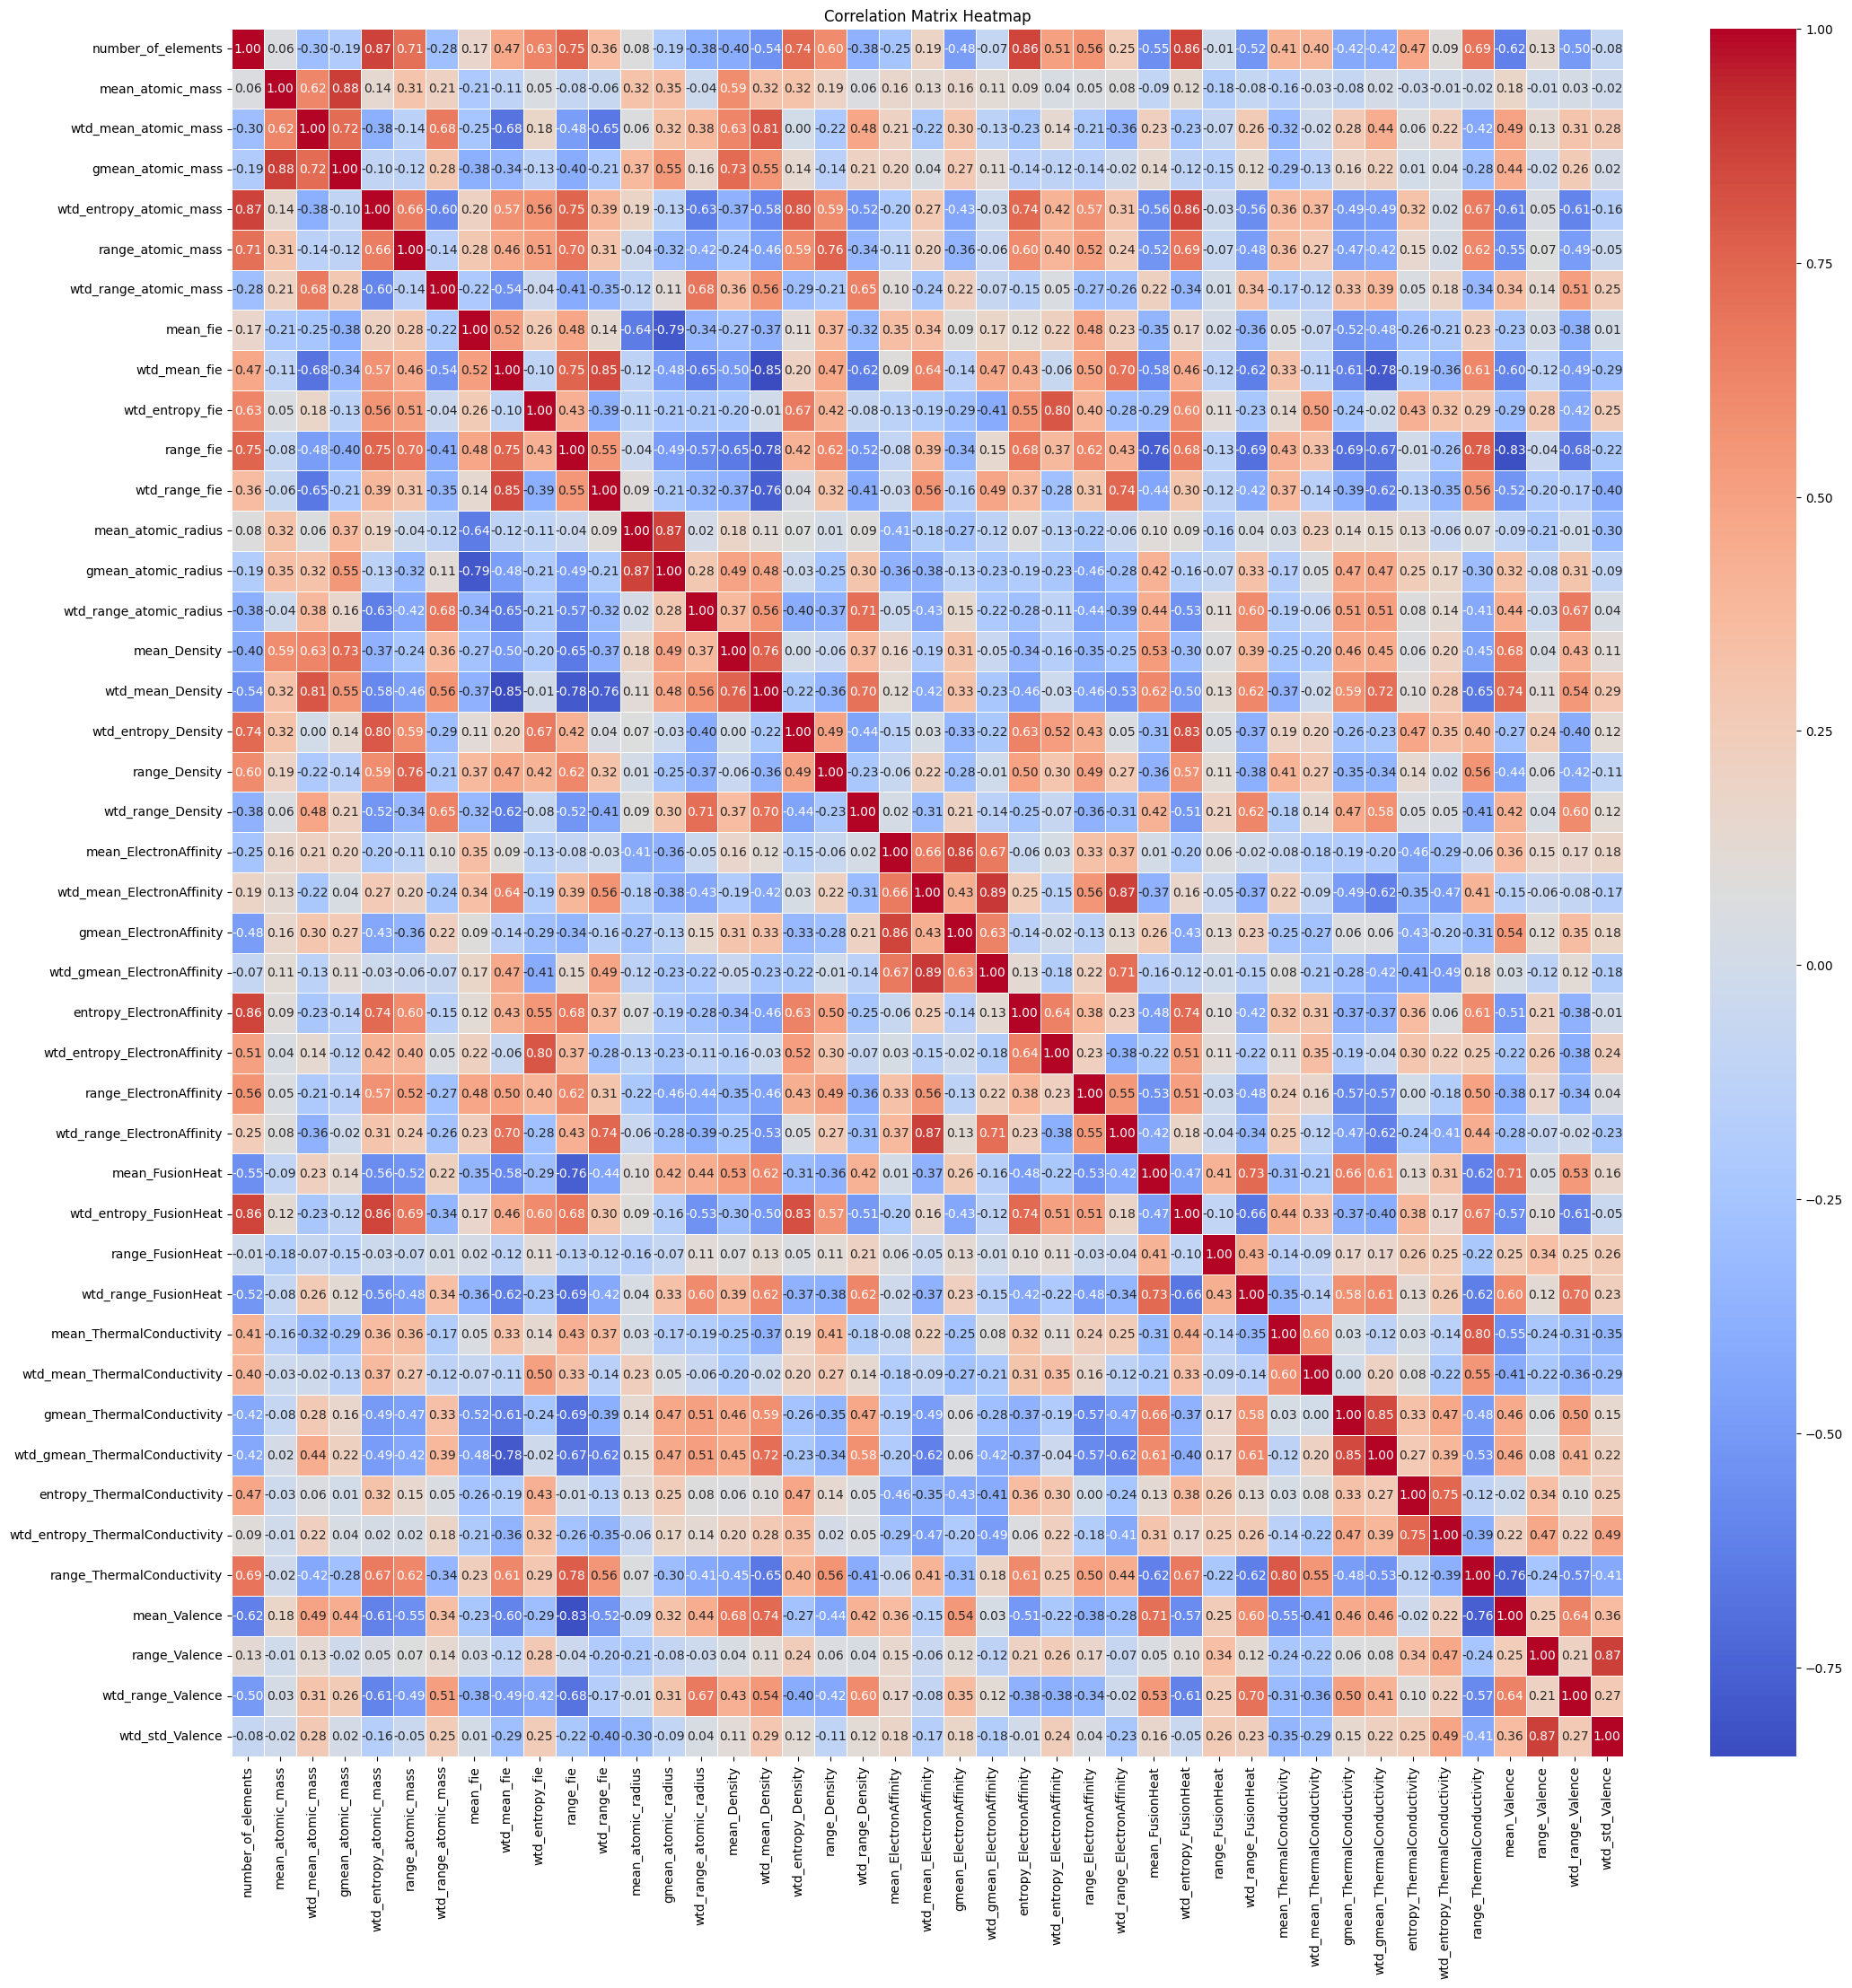

Nuevo número de variables: 43


In [15]:
column_purge = set()
for i in range(len(corr_matrix.columns)):
  for j in range(i + 1, len(corr_matrix.columns)):
    if abs(corr_matrix.iloc[i, j]) >= 0.9:
      colname = corr_matrix.columns[j]
      column_purge.add(colname)
x = x.drop(columns = column_purge)
print(f"columnas eliminadas por alta correlación: {column_purge}")

corr_matrix = x.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f",linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()
print("Nuevo número de variables:",x.shape[1])

## **División de Datos**

Para comenzar a **entrenar modelos** se debe **dividir la base de datos** en 2. Para esto se usa la función `train_test_split` ya que el siguiente paso el realizar una **selección de características** donde se requiere generar varios modelos de regresión.

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 23)

## **Selección de Características**

Para seleccionar las características que serán utilizadas en los modelos de regresión, se utilizará un **modelo de selección hacia adelante**.

In [17]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import r2_score
model = LinearRegression()
model.fit(x_train, y_train)
sfs_f = SFS(model, k_features = 'best', forward = True, scoring = 'r2', cv = 10, verbose = 1)
sfs_f.fit(x_train, y_train)
selected_features_f = list(sfs_f.k_feature_names_)
print("\n✅ Características seleccionadas:")
print(f"Índices: {sfs_f.k_feature_idx_}")
print(f"Nombres: {selected_features_f}")

x_selected_train = x_train[selected_features_f]
x_selected_test = x_test[selected_features_f]

Features: 43/43


✅ Características seleccionadas:
Índices: (0, 1, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42)
Nombres: ['number_of_elements', 'mean_atomic_mass', 'gmean_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'mean_fie', 'wtd_mean_fie', 'wtd_entropy_fie', 'mean_atomic_radius', 'gmean_atomic_radius', 'wtd_range_atomic_radius', 'mean_Density', 'wtd_entropy_Density', 'range_Density', 'wtd_range_Density', 'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity', 'range_ElectronAffinity', 'wtd_range_ElectronAffinity', 'mean_FusionHeat', 'wtd_entropy_FusionHeat', 'range_FusionHeat', 'wtd_range_FusionHeat', 'mean_ThermalConductivity', 'wtd_mean_ThermalConductivity', 'gmean_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductiv

Se utilizó el **método de selección hacia adelante** debido a que **se busca un modelo con el menor número de variables posibles** para que tenga un mejor rendimiento. El **número de variables disminuyó**, lo cual hará el entrenamiento del modelo **más fácil de llevar a nivel computacional** y también lo hace **más interpretable**.

## **Modelo de Regresión Lineal**

Primero se genera un modelo de regresión lineal utilizando la función `LinearRegression` de `sklearn.linear_model.`

Modifiqué las variables de entrada para que solo tomaran en cuenta las variables **seleccionadas tras el proceso de selección de características**. Utilizando la función `fit()` se entreno el modelo con los datos de entrenamiento y después con la función `predict()` se probó el modelo con los datos de prueba. También se uso la función `r2_score` y se calculo la **R^2** del modelo para conocer su desempeño. La gráfica muestra el desempeño del modelo contra los valores reales.


📊 R^2 en datos de prueba: 0.6561


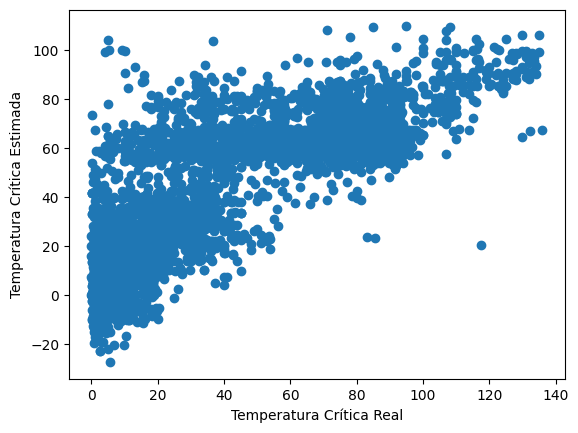

In [18]:
model.fit(x_selected_train, y_train)

y_pred = model.predict(x_selected_test)

r2_linear = r2_score(y_test,y_pred)
plt.scatter(y_test, y_pred)
plt.xlabel("Temperatura Crítica Real")
plt.ylabel("Temperatura Crítica Estimada")
print(f"\n📊 R^2 en datos de prueba: {r2_linear:.4f}")

## **Modelo de Regresión Polinomial**

Ahora se probará un modelo de **regresión polinomial**. Para este se usa la función `PolynomialFeatures` de `sklearn.preprocessing`. Se usa un grado de **2** para equilibrar entre **eficiencia computacional y buena calidad**. Se transforman los datos con la función `fit_transform` y de nuevo utilizando la función `LinearRegression` se entrena el modelo polinomial. Una vez entrenado, se prueba con los datos de validación y se calcula su **R^2**. La gráfica muestra el desempeño del modelo contra los valores reales.

R^2: 0.7827518846207967


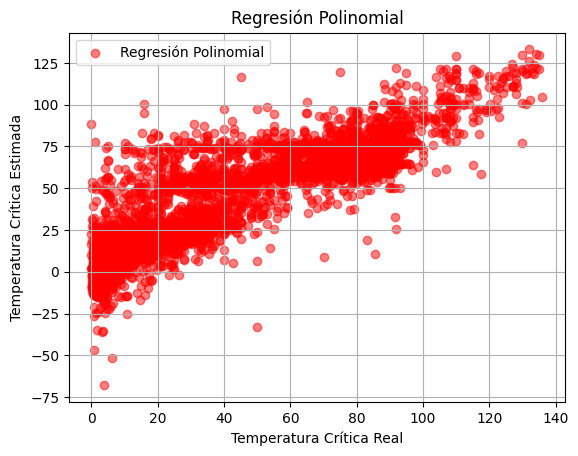

In [42]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_selected_train)
x_poly_test = poly.fit_transform(x_selected_test)
model = LinearRegression()
model.fit(x_poly_train, y_train)


yhat_poly = model.predict(x_poly_test)

r2_poly = r2_score(y_test,yhat_poly)
print("R^2:",r2_poly)
plt.scatter(y_test,yhat_poly, color = "red",alpha = 0.5, label="Regresión Polinomial")
plt.title("Regresión Polinomial")
plt.xlabel("Temperatura Crítica Real")
plt.ylabel("Temperatura Crítica Estimada")
plt.legend()
plt.grid(True)
plt.show()

## **Métricas de Error y Linealidad**

Para comparar ambos modelos se calcula el mean square error (**MSE**) y la **R^2** de ambos modelos de acuerdo con el desempeño de sus predicciones en los datos de validación.

In [43]:
from sklearn.metrics import mean_squared_error

mse_poly = mean_squared_error(y_test,yhat_poly)
mse_linear = mean_squared_error(y_test,y_pred)
print("MSE de Regresión Lineal:",mse_linear)
print("R^2 de Regresión Lineal:",r2_linear)
print("MSE de Regresión Polinomial:",mse_poly)
print("R^2 de Regresión Polinomial:",r2_poly)

MSE de Regresión Lineal: 407.421780417495
R^2 de Regresión Lineal: 0.656058819903386
MSE de Regresión Polinomial: 257.3452063381222
R^2 de Regresión Polinomial: 0.7827518846207967


Tras comparar ambos modelos, el **modelo de regresión polinomial** es el claro ganador ya que tiene un **menor error (MSE)** y un **mayor nivel de linealidad (R^2)** por lo tanto será el modelo seleccionado.

## **Inferencia con el Modelo**
Tras obtener el modelo ganador, se utiliza la librería `statsmodels.api` para **obtener información relevante para generar inferencias** a partir del modelo.

In [44]:
import statsmodels.api as sm
poly_inf = sm.OLS(y_train,x_poly_train).fit()
print(poly_inf.summary())

                            OLS Regression Results                            
Dep. Variable:          critical_temp   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     64.09
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        06:36:51   Log-Likelihood:                -44811.
No. Observations:               10966   AIC:                         9.118e+04
Df Residuals:                   10186   BIC:                         9.688e+04
Df Model:                         779                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -516.0799    370.659     -1.392      0.1

Al ser un modelo polinomial de segundo grado basado en 38 variables, **es difícil interpretar a la perfección** cada uno de los coeficientes, ya que son un total de 779. Sin embargo se pueden realizar algunas inferencias.

Por ejemplo:
- **El término x^5 reduce la temperatura crítica de un superconductor entre -4.417 y -0.85 grados con un 95% de confianza.**
- **El término x^117 aumenta la temperatura crítica de un superconductor entre 0.038 y 0.103 grados con un 95% de confianza.**
- **El término x^424 aumenta la tempratura crítica de un superconductor entre 0.003 y 0.008 grados con un 95% de confianza.**

En general, utilizando estos datos y el modelo, se pueden obtener conclusiones del **efecto de las variables en la temperatura crítica**. Aún así, **no se puede saber el efecto específico de cada variable**, ya que al tener varias y trabajar con una regresión polinomial de grado 2, **cada término representa no solo el cuadrado de cada variable si no también las interacciones** entre cada par de variables posibles.

Con esto en mente, se puede concluir que **el modelo es bueno para realizar predicciones**, sin embargo, para realizar inferencias, sería mejor considerar modelos más interpretables como la regresión lineal.

Referencias:
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/464/superconductivty+data)
- [A Data-Driven Statistical Model for Predicting the Critical
Temperature of a Superconductor](https://arxiv.org/pdf/1803.10260)